## Predicting Forest Fires

In [1]:
import pandas as pd
import numpy as np

fires = pd.read_csv("fires.csv", usecols=lambda x: x != "Unnamed: 0")
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [2]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    469 non-null    float64
 5   DMC     496 non-null    float64
 6   DC      474 non-null    float64
 7   ISI     515 non-null    float64
 8   temp    496 non-null    float64
 9   RH      487 non-null    float64
 10  wind    482 non-null    float64
 11  rain    485 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(9), int64(2), object(2)
memory usage: 52.6+ KB


In [3]:
from sklearn.linear_model import LinearRegression

fires_reference = fires[["wind", "temp", "area"]].dropna()
reference_X = fires_reference[["wind", "temp"]]

reference = LinearRegression()

## Data Processing
First, we'll convert the `month` column into a categorical feature. Instead of using the strings, we'll convert it into an indicator for the summer months in the northern hemisphere.

For the sake of completion, we'll impute all of the features so that we can have the biggest set to choose from for sequential feature selection. We'll go with K-nearest neighbors imputation since we expect area damage to be similar among similar fires.

<AxesSubplot:>

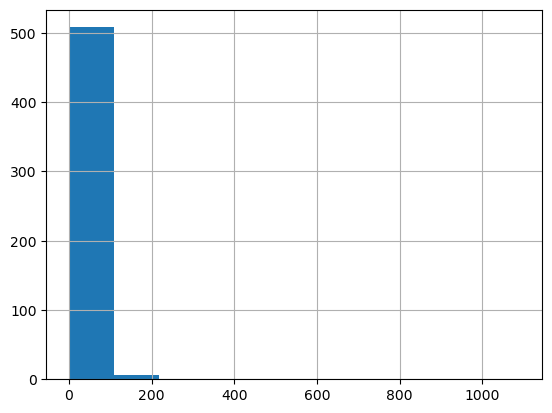

In [4]:
fires["area"].hist()

The outcome is highly right-skewed with extremely damaging fires. Furthermore, many of the rows have outcome values that are zero or near-zero. It might be worth it to log-transform the data. Note though that some of the outcomes are actually 0, so we can add `1` to prevent any errors. Recall that `Log(0)` is undefined.

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

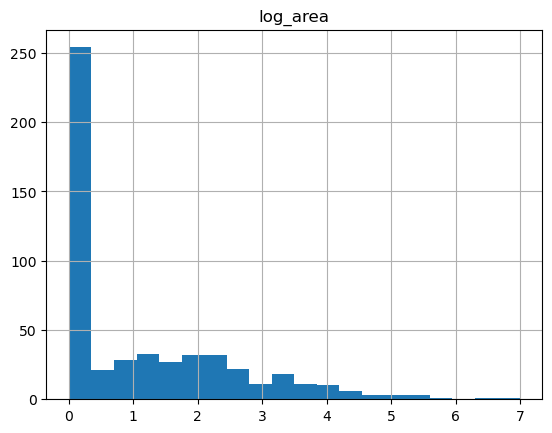

In [5]:
fires["log_area"] = np.log(fires["area"] + 1)

fires.hist("log_area", bins = 20)

We can see that performing a log-transformation doesn't produce a bell-shaped distribution, but it does spread out the data a bit more than without the transformation. It's probably the case that most fires do not appreciably damage the forest, so we would be mistaken in removing all of these rows.

Instead of using month directly, we'll derive another feature called `summer` that takes a value of 1 when the fire occurred during the summer. The idea here is that summer months are typically hotter, so fires are more likely. The summer months in northeast region of Portugal ranges from [june to august](https://www.portugalpathways.io/documentation-posts/a-guide-to-portuguese-weather#:~:text=Summer(June%20to%20August)%3A,C(77%C2%B0F).&text=Autumn(September%20to%20November)%3A,C%20(68%C2%B0F).).

In [6]:
# checking how the months are written in the month column

fires["month"].unique()

array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
       'dec', 'may', 'nov'], dtype=object)

In [7]:
def is_summer_month(month):
    if month in ["jun", "jul", "aug"]:
        return 1
    else:
        return 0

fires["summer"] = fires["month"].apply(is_summer_month)
fires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,summer
0,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0,0.0,0
1,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0,0.0,0
2,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0,0.0,0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0,0.0,0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0,0.0,0


In [8]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

fires_missing = fires[fires.columns[4:12]] # FFMC to rain

imputed = pd.DataFrame(imp.fit_transform(fires_missing), columns = fires.columns[4:12])

imputed.head()

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0


Let's examine the data for outliers using boxplots:

<AxesSubplot:>

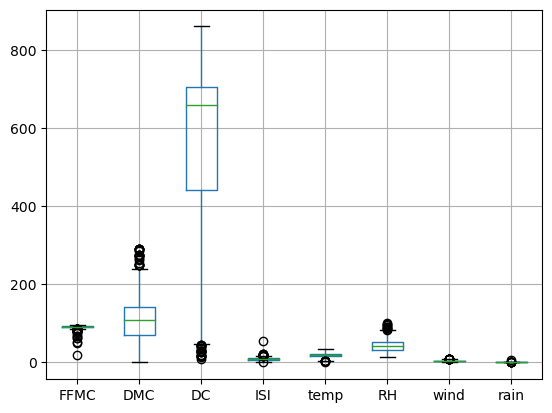

In [9]:
imputed.boxplot(column=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"])

The dots indicate that there are some outliers in the data. Let's examine the number of outliers in each of the columns.

In [10]:
for col in imputed:

    quartiles = np.percentile(fires[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")

The FFMC column has 0 according to the boxplot method.
The DMC column has 0 according to the boxplot method.
The DC column has 0 according to the boxplot method.
The ISI column has 0 according to the boxplot method.
The temp column has 0 according to the boxplot method.
The RH column has 0 according to the boxplot method.
The wind column has 0 according to the boxplot method.
The rain column has 0 according to the boxplot method.


Despite the visual cue in the boxplots, the actual calculations show no outliers. In this case, we will leave the dataset as it is.

Now that the dataset has been examined for missing values and outliers, we can standardize it. These standardized values will aid with standardization. After that, we'll add the `summer` feature back into the dataset.

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns = fires.columns[4:12])

scaled_df = pd.concat([fires["summer"], scaled], axis=1)

scaled_df.head()

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268


## Data Visualization 

Visualizations can assist us in comprehending how the features relate to the outcome. These visualizations also serve as starting points to employ a specific model. Furthermore, these charts may be effective in discouraging the usage of one particular model. For example, if a feature-outcome relationship does not show a quadratic trend, it is reasonable to avoid using a quadratic model.

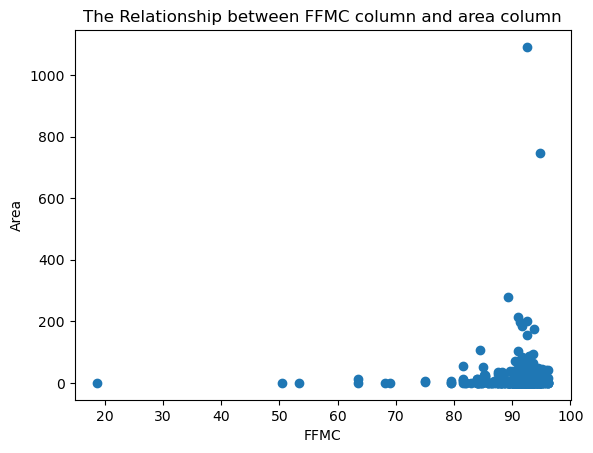

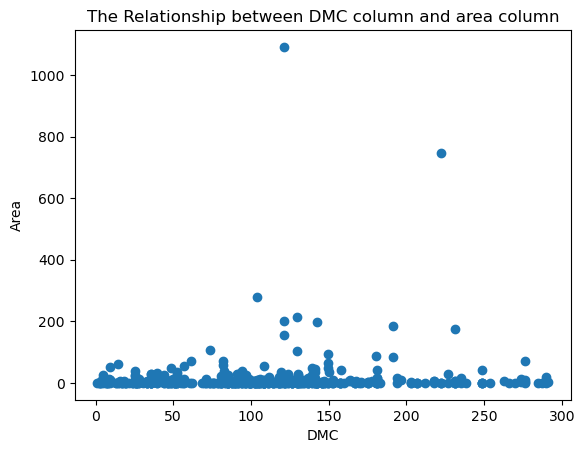

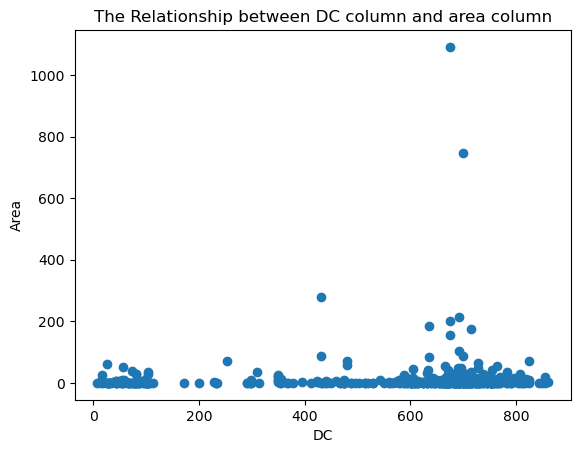

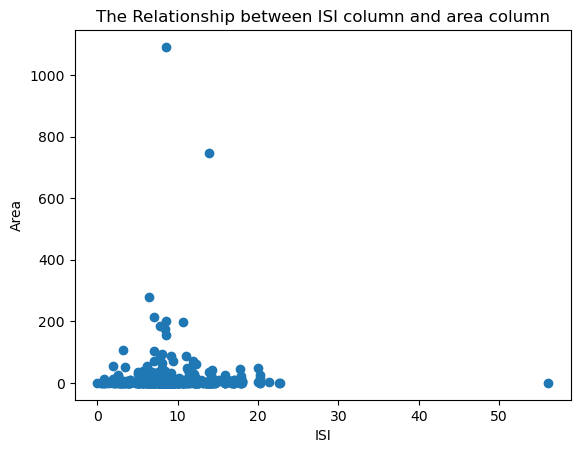

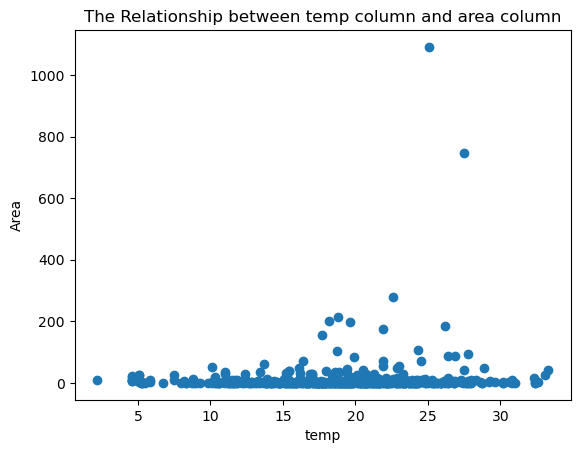

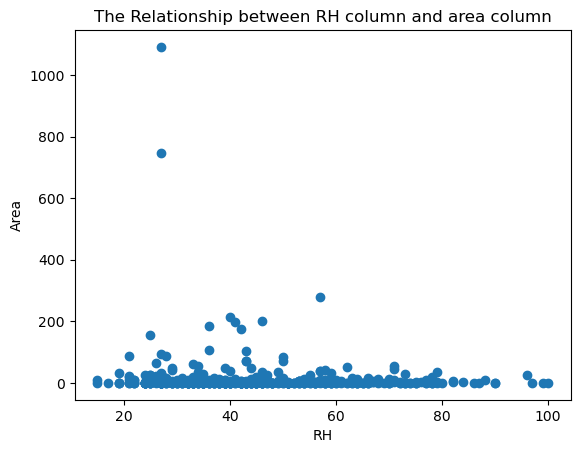

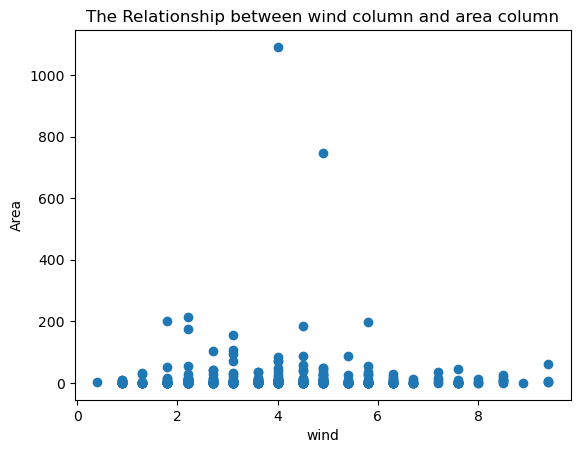

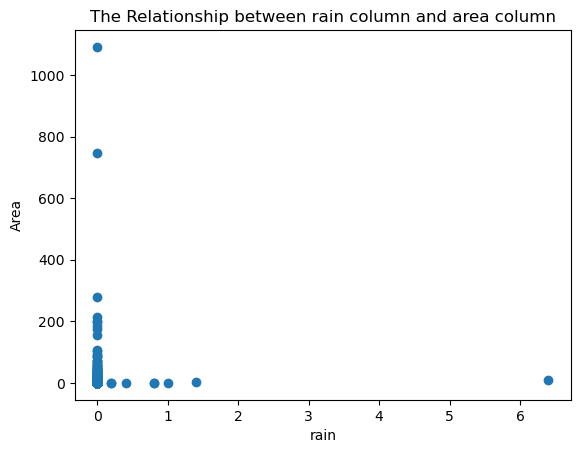

In [12]:
import matplotlib.pyplot as plt

for i in fires.columns[4:12]:
    plt.scatter(fires[i], fires["area"])
    plt.title(F"The Relationship between {i} column and area column")
    plt.xlabel(F"{i}")
    plt.ylabel("Area")
    plt.show()

## Subset Selection

In [13]:
from sklearn.feature_selection import SequentialFeatureSelector

y = fires["log_area"]

sfs_model = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

forward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="forward")

forward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4, 
                                     direction="forward")

forward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                       n_features_to_select=6, 
                                       direction="forward")

forward2.fit(scaled_df, y)
forward4.fit(scaled_df, y)
forward6.fit(scaled_df, y)

print("Features selected in 2 feature model:", forward2.get_feature_names_out())
print("Features selected in 4 feature model:", forward4.get_feature_names_out())
print("Features selected in 6 feature model:", forward6.get_feature_names_out())

Features selected in 2 feature model: ['FFMC' 'DC']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [14]:
backward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="backward")

backward4 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=4, 
                                     direction="backward")

backward6 = SequentialFeatureSelector(estimator=sfs_model,
                                       n_features_to_select=6, 
                                       direction="backward")

backward2.fit(scaled_df, y)
backward4.fit(scaled_df, y)
backward6.fit(scaled_df, y)

print("Features selected in 2 feature model:", backward2.get_feature_names_out())
print("Features selected in 4 feature model:", backward4.get_feature_names_out())
print("Features selected in 6 feature model:", backward6.get_feature_names_out())

Features selected in 2 feature model: ['DC' 'wind']
Features selected in 4 feature model: ['FFMC' 'DC' 'RH' 'wind']
Features selected in 6 feature model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


Based on the features chosen by forward and backward selection, it seems like `DC`, `wind` and `FFMC` seem to be the most impactful on predicting `log_area`.

In [15]:
fw2_model = LinearRegression() # .fit(scaled_df[forward2.get_feature_names_out()], y)
fw4_model = LinearRegression() # .fit(scaled_df[forward4.get_feature_names_out()], y)
fw6_model = LinearRegression() # .fit(scaled_df[forward6.get_feature_names_out()], y)

bw2_model = LinearRegression() # .fit(scaled_df[backward2.get_feature_names_out()], y)
bw4_model = LinearRegression() # .fit(scaled_df[backward4.get_feature_names_out()], y)
bw6_model = LinearRegression() # .fit(scaled_df[backward6.get_feature_names_out()], y)

## Developing Candidate Models

Another approach we might consider taking is using regularized versions of linear regression. Fires have many factors that can increase the damaage they have, so it seems unhelpful to restrict our model to a univariate, non-linear model.

In [16]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(scaled_df, y)
lasso.fit(scaled_df, y)

print(F"Ridge tuning parameter: {ridge.alpha_}\n\nLASSO tuning parameter: {lasso.alpha_}\n\n")

print(F"Ridge coefficients: {ridge.coef_}\n\nLASSO coefficients: {lasso.coef_}")

Ridge tuning parameter: 1372.2342342342342

LASSO tuning parameter: 10000.0


Ridge coefficients: [-0.01455017  0.01311215  0.02006457  0.02004741 -0.01073465  0.01297049
 -0.01489714  0.02670554  0.00816103]

LASSO coefficients: [-0.  0.  0.  0. -0.  0. -0.  0.  0.]


The LASSO tuning parameter always seems to be on the extreme. Given that the outcome has many small values, it suggests that having no features at all is better than having any. We'll try to home in on a better tuning parameter value below by choosing a smaller range to pick from.

In [17]:
ridge = RidgeCV(alphas = np.linspace(1000, 1500, num=1000))
ridge.fit(scaled_df, y)

print(F"Ridge tuning parameter: {ridge.alpha_}")

Ridge tuning parameter: 1371.3713713713714


We'll use this value in k-fold cross-validation, rounded to the hundredths place. We'll use a ridge regression and choose not to use a LASSO model here since the regularization results aren't helpful.

In [18]:
from sklearn.model_selection import cross_val_score 

reference_cv = cross_val_score(reference, scaled_df[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")

fw2_cv = cross_val_score(fw2_model, scaled_df[forward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, scaled_df[forward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, scaled_df[forward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")

bw2_cv = cross_val_score(bw2_model, scaled_df[backward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, scaled_df[backward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, scaled_df[backward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")

ridge_cv = cross_val_score(ridge, scaled_df, y, cv = 5, scoring = "neg_mean_squared_error")

In [19]:
print(F"Reference Model, Avg Test MSE: {np.mean(reference_cv)} SD: {np.std(reference_cv)}\n\n")

print(F"Forward-2 Model, Avg Test MSE: {np.mean(fw2_cv)} SD: {np.std(fw2_cv)}")
print(F"Forward-4 Model, Avg Test MSE: {np.mean(fw4_cv)} SD: {np.std(fw4_cv)}")
print(F"Forward-6 Model, Avg Test MSE: {np.mean(fw6_cv)} SD: {np.std(fw6_cv)}\n\n")

print(F"Backward-2 Model, Avg Test MSE: {np.mean(bw2_cv)} SD: {np.std(bw2_cv)}")
print(F"Backward-4 Model, Avg Test MSE: {np.mean(bw4_cv)} SD: {np.std(bw4_cv)}")
print(F"Backward-6 Model, Avg Test MSE: {np.mean(bw6_cv)} SD: {np.std(bw6_cv)}\n\n")

print(F"Ridge Model, Avg Test MSE: {np.mean(bw6_cv)} SD: {np.std(bw6_cv)}")

Reference Model, Avg Test MSE: -2.204650013004116 SD: 1.0600403553786375


Forward-2 Model, Avg Test MSE: -2.1735431721198535 SD: 1.0208083278697586
Forward-4 Model, Avg Test MSE: -2.193528106772711 SD: 1.0004774710977682
Forward-6 Model, Avg Test MSE: -2.2397225539348753 SD: 1.0123323877770345


Backward-2 Model, Avg Test MSE: -2.173357302739327 SD: 1.0038109503795956
Backward-4 Model, Avg Test MSE: -2.193528106772711 SD: 1.0004774710977682
Backward-6 Model, Avg Test MSE: -2.2397225539348753 SD: 1.0123323877770345


Ridge Model, Avg Test MSE: -2.2397225539348753 SD: 1.0123323877770345


Among our candidate models, the backward selection model using two features performs the best, with an average MSE of -2.17. However, note that this is on the log-scale, so this suggests that the predictions are off by a magnitude of about 2. On the surface, this suggests that the models overall are not good predictors.
##  Examining Model Weaknesses

In [20]:
# using our best model bw2_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = scaled_df[["DC","wind"]]
y = fires["log_area"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

bw2_model = LinearRegression()
bw2_model.fit(X_train, y_train)

y_pred = bw2_model.predict(X_test)

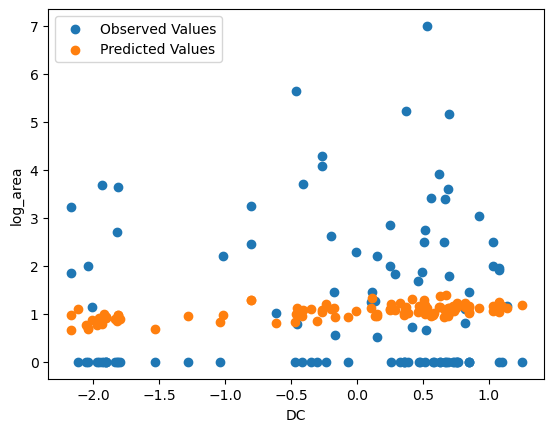

In [21]:

plt.scatter(X_test['DC'], y_test, label='Observed Values')
plt.scatter(X_test['DC'], y_pred, label='Predicted Values')
plt.xlabel('DC')
plt.ylabel('log_area')
plt.legend()
plt.show()

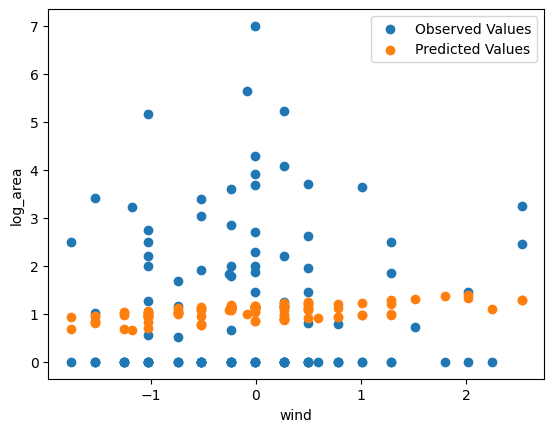

In [22]:
plt.scatter(X_test['wind'], y_test, label='Observed Values')
plt.scatter(X_test['wind'], y_pred, label='Predicted Values')
plt.xlabel('wind')
plt.ylabel('log_area')
plt.legend()
plt.show()

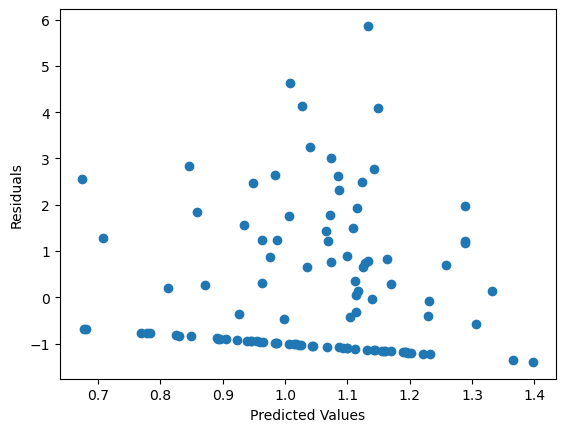

In [23]:
residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

## Conclusion

Visualization of the model accuracy shows that it is not a good predictor. one of the major reason behind this is due to to unevenly distributuion in our outcome.